In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

In [6]:
df = pd.read_csv("/Users/chris/projects/Nature2023MooneyScripts/results/learning_comparison.csv")

In [7]:
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct,Predicted,Ground truth class
0,Human,Human-0,0,0,pre,1,???,dog
1,Human,Human-0,0,0,gray,1,???,dog
2,Human,Human-0,0,0,post,1,???,dog
3,Human,Human-1,1,0,pre,0,???,dog
4,Human,Human-1,1,0,gray,1,???,dog


## Rank human performance

In [8]:
human_df = df[df["Source"] == "Human"]
n_images = len(human_df["Image index"].unique())
n_subjects = len(human_df["Subject"].unique())

corrects = np.full((n_subjects, n_images, 2), np.nan)
for (subject, phase, image_index), small_df in human_df.groupby(
    ["Subject", "Phase", "Image index"]
):
    if phase == "pre":
        corrects[subject, image_index, 0] = small_df["Correct"].astype(int).mean()
    elif phase == "post":
        corrects[subject, image_index, 1] = small_df["Correct"].astype(int).mean()

# Calculate 0, 1 pattern
vote = ((corrects[:, :, 0] == 0) & (corrects[:, :, 1] == 1)).sum(0)
vote

# Top 90 images
top_90_images = vote.argsort()[-90:][::-1]
top_90_images

array([ 75,   3, 140, 134, 121, 158,  76, 174, 142,  87, 120, 118,  96,
        90,  60,  13, 126, 123, 175, 102,  79, 170,   4,   2, 107,  78,
       150, 144, 212,   7,  81, 136, 135,  15, 114, 199, 160,  26, 122,
       200,  20,  29,  74, 117, 155, 154, 115, 151, 100,  98,  77, 105,
        99, 143,  80, 130, 116,  83, 109, 108,  10,  27,  21,  37,  19,
       203,  47,  17, 166,  64,  56,  55,  12,  23,  89,  93,  25,  94,
         5, 193, 196,   8, 197, 186, 205,  88,  73,  69,  33, 156])

In [9]:
# Only keep these 90
df = df[df["Image index"].isin(top_90_images)]

## Find which classes the model couldn't possibly get

In [10]:
to_parse = df[df["Source"] != "Human"]

In [11]:
target_class = df["Ground truth class"]

In [12]:
pred_class = df["Predicted"]

In [13]:
import json

# Load the mapping
mapping = json.load(open("../../data/imagenet_label_to_wordnet_synset.json"))
behavior_mapping = json.load(open("../../data/wordnet_translation.json"))

In [14]:
from nltk.corpus import wordnet as wn

In [15]:
mapper_imagenet_name_2_wn_synset = {}

unknown_class = []
all_target_classes = set(target_class)
for c in all_target_classes:
    has_match = False
    for imagenet_class_d in mapping.values():

        # Get the synset of imagenet class
        synset = wn.synset_from_pos_and_offset("n", int(imagenet_class_d["id"].split("-")[0]))

        if imagenet_class_d["label"] not in mapper_imagenet_name_2_wn_synset:
            mapper_imagenet_name_2_wn_synset[imagenet_class_d["label"]] = synset

        # Get the synset of the target class
        target_synset = wn.synset(behavior_mapping[c])

        # If has a match
        if target_synset in synset.lowest_common_hypernyms(target_synset):
            has_match = True

    if not has_match:
        unknown_class.append(c)

# ImageNet doesn't have person
unknown_class.append("person")

In [16]:
# This is not terribly accurate. Remove unknown_classes that are known to be predicted
final_unknown_class = []
for c in unknown_class:
    if c not in df["Predicted"].unique():
        final_unknown_class.append(c)

In [17]:
final_unknown_class.remove("barrel")

In [18]:
final_unknown_class

['bonsai', 'helicopter', 'anchor', 'chandelier', 'statue', 'person']

In [19]:
check_dropped_df = df.groupby("Image index").agg({"Ground truth class": "first"}).reset_index()
len(check_dropped_df[check_dropped_df["Ground truth class"].isin(final_unknown_class)])

12

## Convert the classes to model's

In [20]:
other_pairs = [
    ("tusker", "elephant"),
    ("scooter", "moped"),
    ("trolley", "trolley"),
    ("trimaran", "boat"),
    ("catamaran", "boat"),
    ("palace", "castle"),
]

# Mark removal of unknown classes
df["to_remove"] = False
for idx, row in df.iterrows():

    if row["Ground truth class"] in final_unknown_class:
        df.loc[idx, "to_remove"] = True
        continue

    if row["Correct"] in ["0", "1"]:
        df.loc[idx, "Correct"] = int(row["Correct"])

    match = False
    for pair in other_pairs:
        if pair[0] in row["Predicted"] and pair[1] in row["Ground truth class"]:
            df.loc[idx, "Correct"] = 1
            match = True
            break

    if match:
        continue

    if row["Source"] == "Model":
        target_name = row["Ground truth class"]
        pred_name = row["Predicted"]

        # This should be ignored
        if pred_name == "crane2":
            pred_name = "crane"

        if target_name == pred_name:
            df.loc[idx, "Correct"] = 1

        else:
            # If the lowest common hypernym is the ground truth or the prediction, count as correct
            imagenet_class_synset = mapper_imagenet_name_2_wn_synset[pred_name]

            # Get the groundtruth synset
            gt_synset = wn.synset(behavior_mapping[target_name])

            # Get the LCH
            lch = imagenet_class_synset.lowest_common_hypernyms(gt_synset)
            if any([lch_synset == gt_synset for lch_synset in lch]):
                df.loc[idx, "Correct"] = 1
            elif any([lch_synset == imagenet_class_synset for lch_synset in lch]):
                df.loc[idx, "Correct"] = 1
            else:
                df.loc[idx, "Correct"] = 0

In [21]:
df_new = df[~df["to_remove"]]
df_new

,Source,Detailed source,Subject,Image index,Phase,Correct,Predicted,Ground truth class,to_remove
72,Human,Human-0,0,2,pre,0,???,ox,False
73,Human,Human-0,0,2,gray,1,???,ox,False
74,Human,Human-0,0,2,post,0,???,ox,False
75,Human,Human-1,1,2,pre,0,???,ox,False
76,Human,Human-1,1,2,gray,1,???,ox,False
...,...,...,...,...,...,...,...,...,...
39371,Model,Model-3-11,11,203,gray,1,throne,chair,False
39376,Model,Model-3-11,11,205,pre,1,tusker,elephant,False
39377,Model,Model-3-11,11,203,post,0,triceratops,chair,False
39379,Model,Model-3-11,11,205,gray,1,"African elephant, Loxodonta africana",elephant,False


In [22]:
df_new.drop(columns=["to_remove"], inplace=True)

/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87350/191651671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(columns=["to_remove"], inplace=True)


In [23]:
df = df_new.drop(columns=["Ground truth class", "Predicted"])
df["Correct"] = df["Correct"].astype(int)
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct
72,Human,Human-0,0,2,pre,0
73,Human,Human-0,0,2,gray,1
74,Human,Human-0,0,2,post,0
75,Human,Human-1,1,2,pre,0
76,Human,Human-1,1,2,gray,1


In [24]:
df.to_clipboard()

## Performance comparison

In [25]:
# Aggregate by subject and source
agg_df = df.drop(columns=["Image index"])
agg_df = agg_df.groupby(["Subject", "Source", "Phase"]).mean(numeric_only=True).reset_index()
agg_df.head(6)

,Subject,Source,Phase,Correct
0,0,Human,gray,0.858974
1,0,Human,post,0.551282
2,0,Human,pre,0.141026
3,0,Model,gray,0.929487
4,0,Model,post,0.637821
5,0,Model,pre,0.326923


In [26]:
# agg_df.to_clipboard()

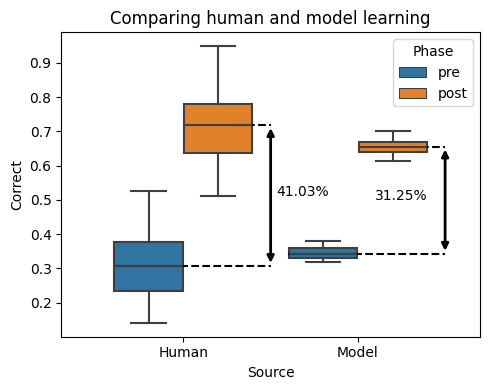

In [27]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post"])

# Plot the differences
mean_pre_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([-0.4, 0.5], [mean_pre_human, mean_pre_human], color="k", linestyle="--")
plt.plot([0.3, 0.5], [mean_post_human, mean_post_human], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(0.5, mean_pre_human), xytext=(0.5, mean_post_human),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_human - mean_pre_human):.2f}%', xy=(0.53, (mean_post_human + mean_pre_human) / 2))

# Plot the differences
mean_pre_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([1-0.4, 1.5], [mean_pre_model, mean_pre_model], color="k", linestyle="--")
plt.plot([1.3, 1.5], [mean_post_model, mean_post_model], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(1.5, mean_pre_model), xytext=(1.5, mean_post_model),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_model - mean_pre_model):.2f}%', xy=(1.1, (mean_post_model + mean_pre_model) / 2))

# Turn off boundary
plt.title("Comparing human and model learning")
plt.tight_layout()

In [28]:
mean_post_human, mean_post_model

(0.717948717948718, 0.655448717948718)

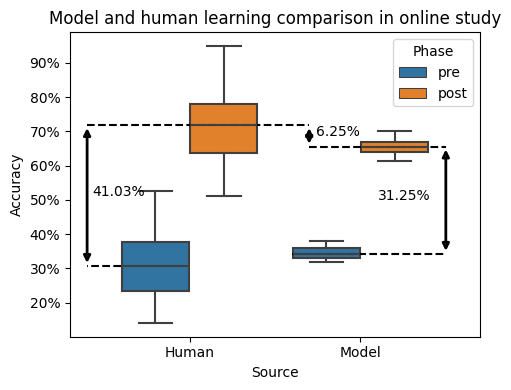

In [29]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post"])

# Plot the differences
mean_pre_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([-0.4, -0.6], [mean_pre_human, mean_pre_human], color="k", linestyle="--")
plt.plot([-0.6, 0.7], [mean_post_human, mean_post_human], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(-0.6, mean_pre_human), xytext=(-0.6, mean_post_human),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_human - mean_pre_human):.2f}%', xy=(-0.57, (mean_post_human + mean_pre_human) / 2))

# Plot the differences
mean_pre_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([1-0.4, 1.5], [mean_pre_model, mean_pre_model], color="k", linestyle="--")
plt.plot([0.7, 1.5], [mean_post_model, mean_post_model], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(1.5, mean_pre_model), xytext=(1.5, mean_post_model),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_model - mean_pre_model):.2f}%', xy=(1.1, (mean_post_model + mean_pre_model) / 2))

# Draw arrow between model and human post mean
plt.annotate('', xy=(0.7, mean_post_human), xytext=(0.7, mean_post_model),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_human - mean_post_model):.2f}%', xy=(0.74, (mean_post_human + mean_post_model) / 2))

# Make y axis Accuracy percentage
plt.yticks(np.arange(0.2, 1, 0.1), [f"{int(100 * i)}%" for i in np.arange(0.2, 1, 0.1)])
plt.ylabel("Accuracy")

# Turn off boundary
plt.title("Model and human learning comparison in online study")
plt.tight_layout()

<Axes: xlabel='Phase', ylabel='Correct'>

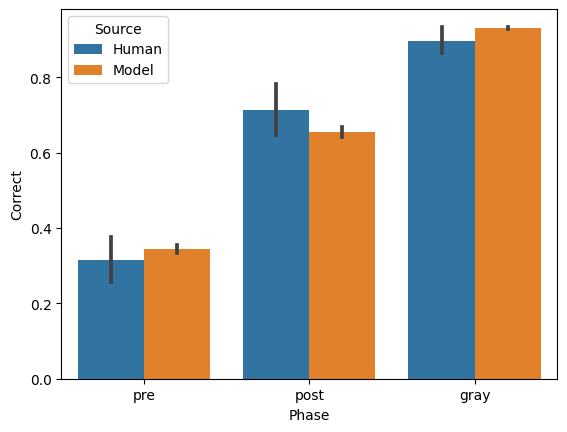

In [30]:
sns.barplot(data=agg_df, x="Phase", y="Correct", hue="Source", order=["pre", "post", "gray"])

In [31]:
agg_df.groupby(["Source", "Phase"]).agg({"Correct": "median"}).reset_index()

,Source,Phase,Correct
0,Human,gray,0.878205
1,Human,post,0.717949
2,Human,pre,0.307692
3,Model,gray,0.929487
4,Model,post,0.655449
5,Model,pre,0.342949


## Behavioral similarity matrix

In [32]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


def get_performance_similarity(df, measure, min_value=-1, shuffle=False):
    curr_df = df.copy()

    # This only has effect on the models
    curr_df = (
        curr_df.groupby(["Subject", "Source", "Image index", "Phase"])
        .mean(numeric_only=True)
        .reset_index()
    )

    # Binarize
    curr_df = curr_df.assign(Correct=curr_df["Correct"] > 0.5)
    curr_df["Subject-Source"] = curr_df["Source"] + "-" + curr_df["Subject"].astype(str)

    container = {"src": [], "dest": [], "type": [], "similarity": []}

    for src, dest in product(curr_df["Subject-Source"].unique(), repeat=2):
        src_df = curr_df[curr_df["Subject-Source"] == src]
        dest_df = curr_df[curr_df["Subject-Source"] == dest]

        # Order by image index
        src_df = src_df.sort_values(by="Image index")
        dest_df = dest_df.sort_values(by="Image index")

        types = []

        # What type of interaction is this?
        if "model" in src.lower():
            types.append("model")
        else:
            types.append("human")

        if "model" in dest.lower():
            types.append("model")
        else:
            types.append("human")

        container["type"].append("->".join(types))

        # Append to container
        container["src"].append(src)
        container["dest"].append(dest)

        filtered_src_df = src_df.sort_values(by=["Image index", "Phase"])
        if shuffle:
            filtered_dest_df = dest_df.sample(frac=1).reset_index(drop=True)
        else:
            filtered_dest_df = dest_df.sort_values(by=["Image index", "Phase"])

        src_corrects = filtered_src_df["Correct"].values
        dest_corrects = filtered_dest_df["Correct"].values

        container["similarity"].append(measure(src_corrects, dest_corrects))

    # Create a dataframe
    return pd.DataFrame(container)


def plot_performance_comparison(df, measure, min_value=-1, shuffle=False):
    df = get_performance_similarity(df, measure, min_value, shuffle)

    # Get the matrix
    pivoted = pd.pivot_table(
        df, index="src", columns="dest", values="similarity", aggfunc=np.median
    )

    # Draw the heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        pivoted,
        linewidth=1,
        linecolor="w",
        square=True,
        ax=ax,
        cmap="coolwarm",
        vmin=min_value,
        vmax=1,
    )

    # Turn off x, y label
    plt.xlabel("")
    plt.ylabel("")

    ax.set_title(f"Similarity of decision making")
    fig.tight_layout()
    plt.show()

    return pivoted, df

In [33]:
from scipy.stats import wilcoxon, pearsonr, mannwhitneyu

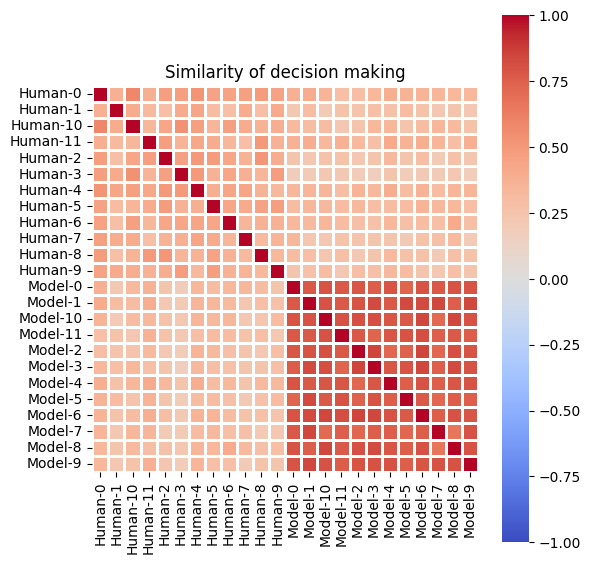

In [34]:
_, sim_df = plot_performance_comparison(df, measure=lambda x,y: pearsonr(x,y)[0], min_value=-1)
human_df = sim_df[sim_df["type"] == "human->human"]
human_df = human_df[human_df["src"].str.split("-").str[1] < human_df["dest"].str.split("-").str[1]]
human_similarities = human_df["similarity"].values

model_human_df = sim_df[sim_df["type"] == "human->model"]
model_human_similarities = model_human_df["similarity"].values

model_df = sim_df[sim_df["type"] == "model->model"]
model_df = model_df[model_df["src"].str.split("-").str[1] < model_df["dest"].str.split("-").str[1]]
model_similarities = model_df["similarity"].values

Similarity between human and models is not as high as humans, but still significantly above 0. Within models, similarity is much higher.

In [35]:
len(human_similarities)

66

In [36]:
len(model_human_similarities)

144

In [37]:
np.median(model_human_similarities)

0.28897328507682873

In [38]:
wilcoxon(model_human_similarities, alternative="greater")[1], wilcoxon(human_similarities, alternative="greater")[1], wilcoxon(model_similarities, alternative="greater")[1]

(1.112927682528275e-25, 8.20474233813614e-13, 8.203678617022344e-13)

In [39]:
np.median(model_similarities), np.median(human_similarities), np.median(model_human_similarities)

(0.7891974961223138, 0.4088308810515854, 0.28897328507682873)

In [40]:
model_similarities.mean(), human_similarities.mean(), model_human_similarities.mean()

(0.7847082138085975, 0.4102395750584149, 0.2892091242053731)

In [41]:
np.percentile(model_similarities, [2.5, 97.5]), np.percentile(human_similarities, [2.5, 97.5]), np.percentile(model_human_similarities, [2.5, 97.5])

(array([0.71897814, 0.84214993]),
 array([0.28541688, 0.53299174]),
 array([0.19145832, 0.39773264]))

In [42]:
mannwhitneyu(model_similarities, human_similarities)[1], mannwhitneyu(model_human_similarities, human_similarities)[1]

(3.761353089356019e-23, 2.929057696208218e-22)

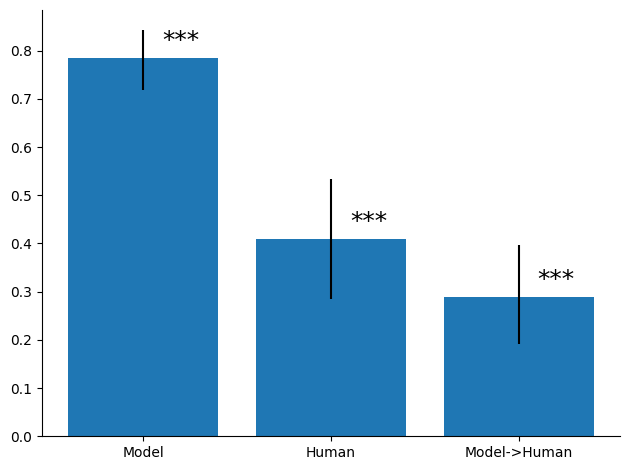

In [43]:
values = np.array(
    [
        model_similarities.mean(),
        human_similarities.mean(),
        model_human_similarities.mean(),
    ]
)
errors = np.array(
    [
        np.percentile(model_similarities, [2.5, 97.5]),
        np.percentile(human_similarities, [2.5, 97.5]),
        np.percentile(model_human_similarities, [2.5, 97.5]),
    ]
).T
errors = abs(errors - np.expand_dims(values, 0))

plt.bar(
    x=["Model", "Human", "Model->Human"],
    height=values,
    yerr=errors,
)
plt.tight_layout()

# Annotate each bar with significance level
plt.annotate("***", xy=(0 + 0.2, values[0] + 0.02), ha="center", fontsize=18)
plt.annotate("***", xy=(1 + 0.2, values[1] + 0.02), ha="center", fontsize=18)
plt.annotate("***", xy=(2 + 0.2, values[2] + 0.02), ha="center", fontsize=18)

# Remove top and right spines
plt.gca().spines[["top", "right"]].set_visible(False)
plt.annotate("*", xy=("Model", 0.9))
plt.show()

## Find noise ceiling

In [44]:
human_df = df[df["Source"] == "Human"]

In [45]:
lower_nc = 0

for chosen_subject in human_df["Subject"].unique():
    subject_df = human_df[human_df["Subject"] == chosen_subject]
    other_df = human_df[human_df["Subject"] != chosen_subject]

    subject_df = subject_df.sort_values(by=["Image index", "Phase"])
    other_df = (
        other_df.groupby(["Image index", "Phase"])
        .agg({"Correct": "mean"})
        .reset_index()
    )

    subject_corrects = subject_df["Correct"].values
    other_corrects = other_df["Correct"].values

    lower_nc += np.arctanh(pearsonr(subject_corrects, other_corrects)[0])

lower_nc = np.tanh(lower_nc / len(human_df["Subject"].unique()))
lower_nc

0.6049935876164747

In [46]:
upper_nc = 0

full_df = (
    human_df.sort_values(by=["Image index", "Phase"])
    .groupby(["Image index", "Phase"])
    .agg({"Correct": "mean"})
    .reset_index()
)
full_corrects = full_df["Correct"].values

for chosen_subject in human_df["Subject"].unique():
    subject_df = human_df[human_df["Subject"] == chosen_subject]
    subject_df = subject_df.sort_values(by=["Image index", "Phase"])

    subject_corrects = subject_df["Correct"].values
    upper_nc += np.arctanh(pearsonr(subject_corrects, full_corrects)[0])

upper_nc = np.tanh(upper_nc / len(human_df["Subject"].unique()))
upper_nc

0.679914114766134

## Plot similarity to human

In [47]:
model_human_df = sim_df[sim_df["type"] == "human->model"]
model_human_df

,src,dest,type,similarity
1,Human-0,Model-0,human->model,0.376259
3,Human-0,Model-1,human->model,0.402695
5,Human-0,Model-2,human->model,0.291382
7,Human-0,Model-3,human->model,0.334285
9,Human-0,Model-4,human->model,0.386032
...,...,...,...,...
543,Human-11,Model-7,human->model,0.351494
545,Human-11,Model-8,human->model,0.291859
547,Human-11,Model-9,human->model,0.379899
549,Human-11,Model-10,human->model,0.333587


In [48]:
# Only keep same src and same dest
model_human_df["Subject"] = model_human_df["src"].str.split("-").str[1]
model_human_df["Model"] = model_human_df["dest"].str.split("-").str[1]
model_human_df = model_human_df[model_human_df["Subject"] == model_human_df["Model"]]
model_human_df

/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87350/258729786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["Subject"] = model_human_df["src"].str.split("-").str[1]
/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87350/258729786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["Model"] = model_human_df["dest"].str.split("-").str[1]


,src,dest,type,similarity,Subject,Model
1,Human-0,Model-0,human->model,0.376259,0,0
51,Human-1,Model-1,human->model,0.303625,1,1
101,Human-2,Model-2,human->model,0.228241,2,2
151,Human-3,Model-3,human->model,0.170561,3,3
201,Human-4,Model-4,human->model,0.398349,4,4
251,Human-5,Model-5,human->model,0.308428,5,5
301,Human-6,Model-6,human->model,0.300129,6,6
351,Human-7,Model-7,human->model,0.276845,7,7
401,Human-8,Model-8,human->model,0.276206,8,8
451,Human-9,Model-9,human->model,0.245536,9,9


/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87350/2223202770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["Subject"] = model_human_df["Subject"].astype(int)


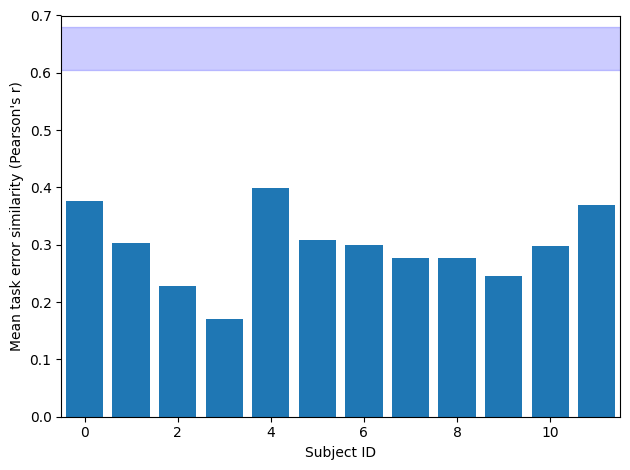

In [49]:
model_human_df["Subject"] = model_human_df["Subject"].astype(int)
model_human_df = model_human_df.sort_values(by="Subject")

plt.bar(model_human_df["Subject"], model_human_df["similarity"])

# Text annotation for the noise ceiling
plt.fill_between(
    [-1, 13],
    [lower_nc, lower_nc],
    [upper_nc, upper_nc],
    color="b",
    alpha=0.2,
)

plt.ylim(0, 0.7)
plt.xlim(-0.5, 11.5)
plt.ylabel("Mean task error similarity (Pearson's r)")
plt.xlabel("Subject ID")
plt.tight_layout()
plt.show()

In [50]:
# Percentage of variance explained by model: 14.24% (95% CI: 5.51%-23.97%)
explained_variance_ratio = model_human_df["similarity"].values**2 / ((lower_nc + upper_nc) / 2)
explained_variance_ratio.mean(), np.percentile(explained_variance_ratio, [2.5, 97.5])

(0.14244811855391018, array([0.05512729, 0.23966942]))

## Image accuracy similarity

In [51]:
human_df = df[df["Source"] == "Human"]
len(human_df)

2808

In [52]:
model_df = df[df["Source"] == "Model"]
model_df["Model subject"] = model_df["Detailed source"].str.split("-").str[1].astype(int)
model_df["Subject"] = model_df["Subject"].astype(int)
model_df = model_df[model_df["Model subject"] == model_df["Subject"]]
model_df

/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87350/2842472773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["Model subject"] = model_df["Detailed source"].str.split("-").str[1].astype(int)
/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87350/2842472773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["Subject"] = model_df["Subject"].astype(int)


,Source,Detailed source,Subject,Image index,Phase,Correct,Model subject
7886,Model,Model-0-0,0,2,pre,0,0
7887,Model,Model-0-0,0,2,gray,1,0
7890,Model,Model-0-0,0,3,pre,1,0
7891,Model,Model-0-0,0,2,post,1,0
7893,Model,Model-0-0,0,4,pre,0,0
...,...,...,...,...,...,...,...
18345,Model,Model-3-3,3,203,gray,1,3
18349,Model,Model-3-3,3,203,post,0,3
18353,Model,Model-3-3,3,205,pre,0,3
18355,Model,Model-3-3,3,205,gray,1,3


In [53]:
human_df_image_accuracy = human_df.groupby(["Image index", "Phase"]).agg({"Correct": "mean"}).reset_index().sort_values(by=["Image index", "Phase"])
model_df_image_accuracy = model_df.groupby(["Image index", "Phase"]).agg({"Correct": "mean"}).reset_index().sort_values(by=["Image index", "Phase"])

In [54]:
r, p = pearsonr(human_df_image_accuracy['Correct'].values, model_df_image_accuracy['Correct'].values)
r, p, len(human_df_image_accuracy['Correct'].values)

(0.4491126097506075, 5.133911047829516e-13, 234)